In [1]:
# import libraries
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' # for tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [2]:
# Set the random seed for replicated results
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load data from CSV file
data = pd.read_csv('dataset.csv', header=None)

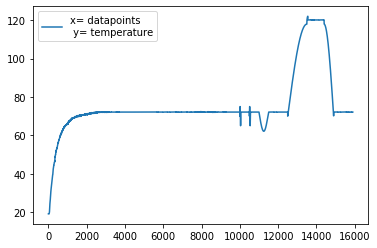

In [4]:
#plot the data 
plt.plot(data,label = 'x= datapoints \n y= temperature')
plt.legend()
plt.show()

In [5]:
raw_train_data = data.iloc[:10000]
raw_test_data = data.iloc[10000:]
raw_train_data.shape, raw_test_data.shape #returns (rows, columns)

((10000, 1), (5900, 1))

In [6]:
### scale the data
scaler = StandardScaler()
scaler = scaler.fit(np.array(raw_train_data).reshape(-1,1))
train_data = scaler.transform(np.array(raw_train_data).reshape(-1,1))
test_data = scaler.transform(np.array(raw_test_data).reshape(-1,1))


In [7]:
### create sequence
TIME_STEPS = 400

def create_sequences(dataset, time_steps=TIME_STEPS):
    """
    Creates sequences from the input data with the given time steps
    """
    X_out = []
    y_out = []
    for i in range(len(dataset) - time_steps):
        X_out.append(dataset[i:i+time_steps])
        y_out.append(dataset[i+time_steps])
    return np.array(X_out), np.array(y_out)

In [8]:
# Assuming you have a single column univariate data called 'data'
# We can create sequences with a specified number of time steps using the create_sequences function

X_train, y_train = create_sequences(train_data, TIME_STEPS)
X_test, y_test = create_sequences(test_data, TIME_STEPS)

# output format (number of sequence, length of batches, number of features)
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (9600, 400, 1)
Testing input shape:  (5500, 400, 1)


In [20]:
# Define LSTM autoencoder model
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(TIME_STEPS, 1)))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(TIME_STEPS))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mse')

In [ ]:
# Train the model and save the history
history = model.fit(X_train, X_train, epochs=16, batch_size=300, validation_data=(X_test, X_test), verbose=1,)


Epoch 1/16
 7/32 [=====>........................] - ETA: 27s - loss: 0.2721

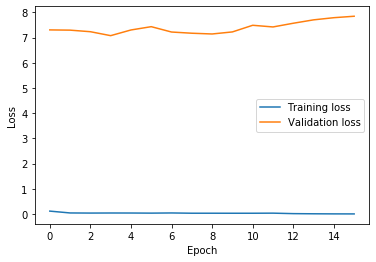

In [11]:
### Plot Training - Validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [12]:
# Make predictions on the train dataset
X_train_pred = model.predict(X_train, verbose=1)


300/300 [==============================] - 32s 108ms/step


In [13]:
# Calculate MAE loss on the train dataset
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
# Flatten the train_mae_loss array
##train_mae_loss = train_mae_loss.flatten()


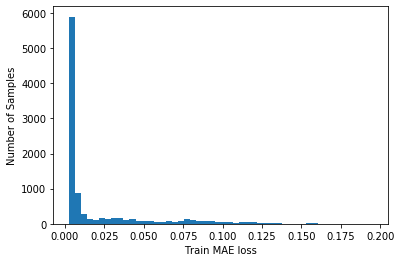

In [14]:
# Visualize MAE loss on the train dataset
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
# Make predictions on the test dataset
X_test_pred = model.predict(X_test, verbose=1)


172/172 [==============================] - 17s 101ms/step


In [17]:
# Calculate MAE loss on the test dataset
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


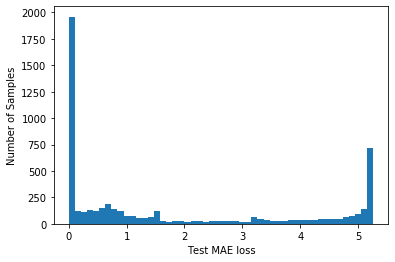

In [18]:
# Visualize MAE loss on the test dataset
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
# Calculate the reconstruction error and define the threshold for anomaly detection
threshold = 1
error = np.mean(np.abs(X_test_pred - X_test), axis=1)


In [19]:
# convert raw_test_data.to_numpy() array to fit in the table
sensor_data = raw_test_data.to_numpy()

# Create anomaly dataframe
anomaly_df = pd.DataFrame(columns=['timesteps', 'test_data', 'test_mae_loss', 'threshold'])

# Add data to the anomaly dataframe
anomaly_df['Timesteps'] = range(TIME_STEPS, len(raw_test_data))
anomaly_df['Sensor_data'] = sensor_data[TIME_STEPS:]
anomaly_df['MAE'] = test_mae_loss

# Set the threshold for anomaly detection
# threshold = 0.5
threshold = np.mean(train_mae_loss) + 3 * np.std(train_mae_loss)

# Add the threshold column to the anomaly dataframe
anomaly_df['threshold'] = threshold

# Find the anomalous data points
anomaly_df['anomaly'] = anomaly_df['test_mae_loss'] > anomaly_df['threshold']

# Print the anomaly dataframe
print(anomaly_df)

     timesteps test_data test_mae_loss  threshold  Timesteps  Sensor_data  \
0          NaN       NaN           NaN   0.113244        400    72.121361   
1          NaN       NaN           NaN   0.113244        401    72.121368   
2          NaN       NaN           NaN   0.113244        402    72.121399   
3          NaN       NaN           NaN   0.113244        403    72.121429   
4          NaN       NaN           NaN   0.113244        404    72.118942   
...        ...       ...           ...        ...        ...          ...   
5495       NaN       NaN           NaN   0.113244       5895    72.121811   
5496       NaN       NaN           NaN   0.113244       5896    72.121788   
5497       NaN       NaN           NaN   0.113244       5897    72.121773   
5498       NaN       NaN           NaN   0.113244       5898    72.121758   
5499       NaN       NaN           NaN   0.113244       5899    72.121750   

           MAE  anomaly  
0     0.056169    False  
1     0.056332    False

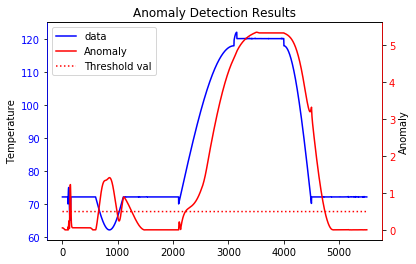

In [34]:
# Plot the anomaly dataframe and test dataset
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color1 = 'blue'
color2 = 'red'

line1 = ax1.plot(anomaly_df.index, anomaly_df['test_data'], color=color1, label = 'data')
line2 = ax2.plot(anomaly_df.index, anomaly_df['loss'], color=color2, label = 'Anomaly')
line3 = ax2.plot(anomaly_df.index, anomaly_df['threshold'], color='red', linestyle = 'dotted', label = 'Threshold val')

#ax2.set_ylim([-0.1, 1.1])
plt.title('Anomaly Detection Results')
plt.xlabel('Test data')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Anomaly')

ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax1.tick_params(axis = 'y', labelcolor = color1)
ax2.tick_params(axis = 'y', labelcolor = color2)

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc = "upper left")

plt.show()


In [35]:
anomaly_df.head(3333)

,timesteps,test_data,val_loss,threshold,loss,anomaly
0,400,72.121361,NaN,0.5,0.058606,False
1,401,72.121368,NaN,0.5,0.059248,False
2,402,72.121399,NaN,0.5,0.059728,False
3,403,72.121429,NaN,0.5,0.060005,False
4,404,72.118942,NaN,0.5,0.060084,False
...,...,...,...,...,...,...
3328,3728,120.128662,NaN,0.5,5.192549,False
3329,3729,120.126694,NaN,0.5,5.193808,False
3330,3730,120.138878,NaN,0.5,5.195061,False
3331,3731,120.164886,NaN,0.5,5.196318,False


In [40]:
test_mae_loss

array([[0.05860642],
       [0.05924772],
       [0.05972807],
       ...,
       [0.00785094],
       [0.00789243],
       [0.00792778]])

In [ ]:
# Initialize variables for anomaly detection
window_size = 100
num_windows = int(len(test_data) / window_size)
consecutive_anomalies = 0

# Check each window of test data for anomalies
for i in range(num_windows):
    start_index = i * window_size
    end_index = start_index + window_size
    
    # Get the anomaly status for this window
    window_anomalies = df['anomaly'][start_index:end_index].values
    
    # Check if any anomalies were detected in this window
    if window_anomalies.sum() == 0:
        print(f"Window {i+1}: Normal Operation")
        consecutive_anomalies = 0
    else:
        print(f"Window {i+1}: Anomaly Detected")
        consecutive_anomalies += 1
        
        # Check if three consecutive windows had anomalies
        if consecutive_anomalies >= 3:
            print("Fault Detected!")
            consecutive_anomalies = 3